In [11]:
#This notebook builds on the code of the notebook "3a_DLmodels_MITBIH", but uses the PTBDB Dataset (and the specific transformations.)
# Aside from changing the naming convention, the PTBDB dataset has to be concatenated, shuffled and then split
# into train and test set. Furthermore, we reduce the output classes to 2 classes instead of 5 in the softmax layer of each DL Model.
# Other than that, all models and the rest of the code are identical to MITBIH Notebook, so that we can compare them.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
if tf.config.experimental.list_physical_devices('GPU'):
    print('GPU is used')
else:
    print('no GPU available, CPU is used instead')

import os

GPU is used


In [12]:
#In this cell, the datasets are downloaded via the KaggleAPI directly from the source. It might be necessary to authentificate first via Webbrowser to make this work.
#FUrthermore, a folder ../data is created, which is on the .gitignore list. In this folder, large files >100mb and the original datasets MITBIH and PTBDB are stored.

from kaggle.api.kaggle_api_extended import KaggleApi

#configuring and authentification with kaggle api. This could be configured so that a authentification mask is shown?
api = KaggleApi()
api.authenticate()

#Configuring the metadata for the ecg heartbeat data (original username etc)
dataset_owner = "shayanfazeli"
dataset_name = "heartbeat"

#Configuring a download path that is NOT in the current github repo (so the big files are not pushed and cause an error!) --> Links to filepaths have to be dynamically adjusted
download_path = "../data/KAGGLE_datasets" #In this case we use the data folder that is in the .gitignore list and therefore not pushed! To keep everything in one local repo.

# Download structure: First check if dataset is already downloaded, else download it and store it in download path (should be outside git repo!)
dataset_folder = os.path.join(download_path, dataset_name)
if not os.path.exists(dataset_folder):
    # Case 1: Dataset path is not created --> Create it and download datasets into it
    api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True)
    print("Datasets are downloaded and unzipped.")
else:
    # Case 2: Folder is created, but datasets might be missing
    missing_files = [] 
    for file_name in ["mitbih_test.csv", "mitbih_train.csv", "ptbdb_abnormal.csv", "ptbdb_normal.csv"]:  # These are the hardcoded names of the datasets that should be downloaded.
        file_path = os.path.join(dataset_folder, file_name)
        if not os.path.exists(file_path):
            missing_files.append(file_name)

    if missing_files:
        # If the list contains missing files, download ALL files and overwrite the old folder.
        api.dataset_download_files(dataset_owner + "/" + dataset_name, path=download_path + "/" + dataset_name, unzip=True, force=True)
        print("Missing data was donwloaded and unzipped. All Datasets are now available.")
    else:
        print("All Datasets are already available.")

#Creating new variable that links to the datasets and can be used in the rest of the code.
path_to_datasets = download_path + "/" + dataset_name 

All Datasets are already available.


In [13]:
np.set_printoptions(precision=4)

In [14]:
#Read in the datasets from PTBDB
normal = pd.read_csv(path_to_datasets + "/" + "ptbdb_normal.csv", header=None)
abnormal = pd.read_csv(path_to_datasets + "/" + "ptbdb_abnormal.csv", header=None)
print("PTBDB Datasets normal and abnormal succesfully loaded into workspace.")

#create combined dataset from normal and abnormal values
dataset = pd.concat([normal, abnormal], axis=0).sample(frac=1.0, random_state =0).reset_index(drop=True)



X = dataset.iloc[:,:-1].values #independent values / features
y = dataset.iloc[:,-1].values #dependent values / target

#we now use the naming convention from MITBIH to reuse the code below
#train, test, train_target, test_target = train_test_split(X, y, test_size = 0.2, random_state=666)
# Split the data into test and train --> This produces np.arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

# for consistency with the code copied from MITBIH Notebook, we need Dataframes as test and train.
train = pd.DataFrame(X_train)
test = pd.DataFrame(X_test)
train_target = pd.Series(y_train)
test_target = pd.Series(y_test)

print("Test and train sets for PTBDB successfully made.")
### From this point on, the same code structure and variables as in the mitbih notebook can be used.

PTBDB Datasets normal and abnormal succesfully loaded into workspace.
Test and train sets for PTBDB successfully made.


In [15]:
#Switches to decide the dataset sampling method and which models should be run
class Config_Sampling:
    oversample = True #Equals to B_SMOTE, otherwise A Original is used
    undersample = False #Never use undersample!
    sample_name = "UNDEFINED_SAMPLE"
    
    
# More than one model can be selected.
Train_Simple_ANN = True #Trains the simple ANN
Train_Simple_CNN = True #Trains the simple CNN
Train_Advanced_CNN = True #Trains the simple CNN

 

In [16]:
oversampler = SMOTE()
undersampler = RandomUnderSampler()

In [17]:
#Based on the configuration in the Config_Sampling Class, the datasets are sampled and the sample name is modified accordingly
if Config_Sampling.oversample:
    train, train_target = oversampler.fit_resample(train, train_target)
    Config_Sampling.sample_name = "PTBDB_B_SMOTE"
    print("Sample Name:", Config_Sampling.sample_name)
elif Config_Sampling.undersample:
    train, train_target = undersampler.fit_resample(train, train_target)
    Config_Sampling.sample_name = "PTBDB_C_RUS"
    print("Sample Name:", Config_Sampling.sample_name)
else: 
    print("Using the original PTBDB dataset")
    Config_Sampling.sample_name = "PTBDB_A_Original"
    print("Sample Name:", Config_Sampling.sample_name)

Sample Name: PTBDB_B_SMOTE


# **Deep Learning Models**

## **Simple Artificial neural Network**
ANN without convolutional layers. Only Dense layers are used. No Pooling, Flattening or Dropping out. Base model for later comparison.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 60)                11280     
                                                                 
 dense_14 (Dense)            (None, 20)                1220      
                                                                 
 dense_15 (Dense)            (None, 20)                420       
                                                                 
 dense_16 (Dense)            (None, 20)                420       
                                                                 
 dense_17 (Dense)            (None, 2)                 42        
                                                                 
Total params: 13382 (52.27 KB)
Trainable params: 13382 (52.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
1683/168

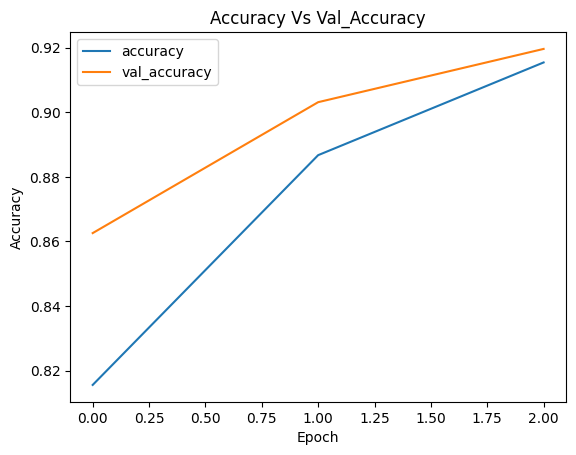

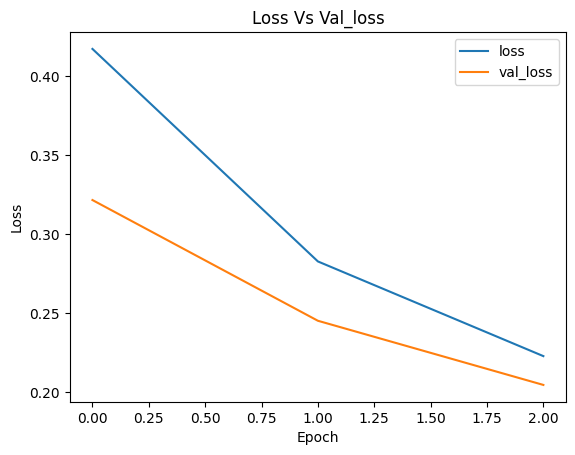

91/91 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

         0.0     0.8296    0.8985    0.8627       818
         1.0     0.9590    0.9279    0.9432      2093

    accuracy                         0.9196      2911
   macro avg     0.8943    0.9132    0.9029      2911
weighted avg     0.9226    0.9196    0.9206      2911

EVERYTHING FINISHED FOR SIMPLE ANN MODEL!


In [18]:
if Train_Simple_ANN == True:
    class Config_ANN:
        epochs = 3 #70 is default (exp1)
        batch_size = 10 #10 is default (exp1)
        exp_name = 42 # Experiment Number counter 
        patience = 70 #10 # is default (exp1)
        initial_learning_rate=0.001 #Default Initial Learning Rate for ADAM: 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        reduce_lr_every_10_epochs = True #Reduce the learning rate each 10 Epochs with the rate defined below. Default is False for exp1.
        lr_reduction_rate = 0.5 # Reduction Rate for reducing each 10 epochs. 0.5 means, that lr is halfed each 10 epochs.
        filepath_checkpoint = '../models/DL_Models/Simple_ANN/experiment_'+str(exp_name) + '_'+str (Config_Sampling.sample_name) +'.weights.h5'
        filepath_accuracy_plot = '../reports/figures/DL_Models/Simple_ANN/experiment_'+str(exp_name) +  '_'+ str (Config_Sampling.sample_name) +'.accuracy_plot.png'
        filepath_loss_plot = '../reports/figures/DL_Models/Simple_ANN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.loss_plot.png'
        filepath_classification_report = '../reports/figures/DL_Models/Simple_ANN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.classification_report.txt'
    
    #Model structure: This is not changed during experiments.
    ann_model = tf.keras.models.Sequential()
    ann_model.add(tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001), input_shape=(187,)))
    ann_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    ann_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    ann_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    ann_model.add(tf.keras.layers.Dense(2, activation='softmax'))

    #Function for the learning rate scheduler
    def lr_scheduler(epoch, lr):
        if Config_ANN.reduce_lr_every_10_epochs and epoch % 10 == 0: # %10 == 0 means each 10 epochs (only then no "rest" after dividing trough 10)
            return lr * Config_ANN.lr_reduction_rate  # reduce the learning rate with the configured rate
        else:
            return lr

    # callback for the learning rate reduction schedule (function)
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    #Model checkpoint: Saves the best model for all epochs with regards to the validation accuracy. Only weights (.h5) are saved.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=Config_ANN.filepath_checkpoint,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    #Early stop callback: If validation accuracy does not change during the last XXX epochs, training is stopped (XXX is configured as patience)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config_ANN.patience)

    #Compilation of model with ADAM and custom lr, sparse_categorical_crossentropy since we have integers as class labels.
    ann_model.compile(optimizer=Config_ANN.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    ann_model.summary() #Model summary for usage in reports or other files.

    #training the model and storing all results in training history. aside from the datasets, all arguments are called from our config-class. Also calling the respective callbacks.
    ann_model_history = ann_model.fit(train, train_target, epochs=Config_ANN.epochs, batch_size = Config_ANN.batch_size, validation_data = (test, test_target), callbacks=[model_checkpoint_callback, early_stop_callback, lr_scheduler_callback])

    #some plots for early interpretion during the run
    plt.plot(ann_model_history.history['accuracy'])
    plt.plot(ann_model_history.history['val_accuracy'])
    plt.legend(["accuracy","val_accuracy"])
    plt.title('Accuracy Vs Val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(Config_ANN.filepath_accuracy_plot)
    plt.show()
    plt.close()


    plt.plot(ann_model_history.history['loss'])
    plt.plot(ann_model_history.history['val_loss'])
    plt.legend(["loss","val_loss"])
    plt.title('Loss Vs Val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(Config_ANN.filepath_loss_plot)
    plt.show()
    plt.close()

    #Predict on test set.
    predictions = ann_model.predict(test).argmax(axis=1) #directly getting classes instead of probabilities.

    #make classification report and save it directly as a file.
    report=classification_report(test_target, predictions, digits=4)
    print(report)
    with open(Config_ANN.filepath_classification_report, 'w') as report_file:
        report_file.write(report)

    print("EVERYTHING FINISHED FOR SIMPLE ANN MODEL!")

else:
    print("Simple ANN Model is not trained and evaluated")
    

## **Simple Convolutional neural Network**
CNN with one convolutional layer. The same Dense layers from Simple ANN Model are used and the first Dense Layer is replaced by a convolutional layer. No Pooling, Flattening or Dropping out. Base model for later comparison. We use a Conv1D layer, because our Input Data is one-dimensional (i.e. is a timeseries). We have sequential and not spatial data.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 185, 32)           128       
                                                                 
 flatten_2 (Flatten)         (None, 5920)              0         
                                                                 
 dense_18 (Dense)            (None, 60)                355260    
                                                                 
 dense_19 (Dense)            (None, 20)                1220      
                                                                 
 dense_20 (Dense)            (None, 20)                420       
                                                                 
 dense_21 (Dense)            (None, 2)                 42        
                                                                 
Total params: 357070 (1.36 MB)
Trainable params: 35707

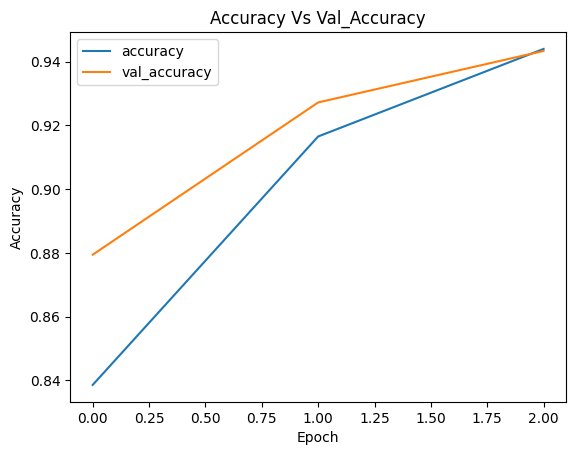

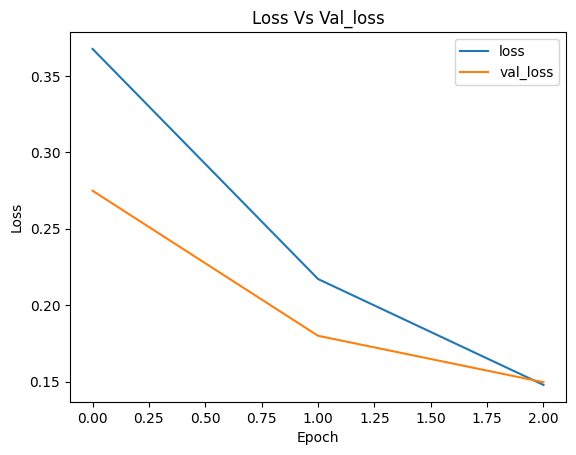

91/91 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

         0.0     0.8749    0.9315    0.9023       818
         1.0     0.9725    0.9479    0.9601      2093

    accuracy                         0.9433      2911
   macro avg     0.9237    0.9397    0.9312      2911
weighted avg     0.9451    0.9433    0.9438      2911

EVERYTHING FINISHED FOR SIMPLE CNN MODEL!


In [19]:
if Train_Simple_CNN == True:
    class Config_CNN:
        epochs = 3 #70 is default (exp1)
        batch_size = 10 #10 is default (exp1)
        exp_name = 42 #Experiment Number counter 
        patience = 70 #10 # is default (exp1)
        initial_learning_rate=0.001 #Default Initial Learning Rate for ADAM: 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        reduce_lr_every_10_epochs = True #Reduce the learning rate each 10 Epochs with the rate defined below. Default is False for exp1.
        lr_reduction_rate = 0.5 # Reduction Rate for reducing each 10 epochs. 0.5 means, that lr is halfed each 10 epochs.
        Conv1_filter_num = 32 # Number of filters in the convolutional layer (more means more shape-variations can be detected) 
        Conv1_filter_size = 3 # Size (e.g. 3 by 3) of single convolutional kernel. More means a more rough approach to detection of patterns.
        filepath_checkpoint = '../models/DL_Models/Simple_CNN/experiment_'+str(exp_name) + '_'+str (Config_Sampling.sample_name) +'.weights.h5'
        filepath_accuracy_plot = '../reports/figures/DL_Models/Simple_CNN/experiment_'+str(exp_name) +  '_'+ str (Config_Sampling.sample_name) +'.accuracy_plot.png'
        filepath_loss_plot = '../reports/figures/DL_Models/Simple_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.loss_plot.png'
        filepath_classification_report = '../reports/figures/DL_Models/Simple_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.classification_report.txt'

    #Model structure: This is not changed during experiments.
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.Conv1D(Config_CNN.Conv1_filter_num, Config_CNN.Conv1_filter_size, activation='relu', input_shape=(187, 1))) # We add one Conv1D layer to the model
    cnn_model.add(tf.keras.layers.Flatten()) # After 
    cnn_model.add(tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    cnn_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    cnn_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    #Function for the learning rate scheduler
    def lr_scheduler(epoch, lr):
        if Config_ANN.reduce_lr_every_10_epochs and epoch % 10 == 0: # %10 == 0 means each 10 epochs (only then no "rest" after dividing trough 10)
            return lr * Config_ANN.lr_reduction_rate  # reduce the learning rate with the configured rate
        else:
            return lr

    # callback for the learning rate reduction schedule (function)
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    #Model checkpoint: Saves the best model for all epochs with regards to the validation accuracy. Only weights (.h5) are saved.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=Config_CNN.filepath_checkpoint,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    #Early stop callback: If validation accuracy does not change during the last XXX epochs, training is stopped (XXX is configured as patience)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config_CNN.patience)

    #Compilation of model with ADAM and custom lr, sparse_categorical_crossentropy since we have integers as class labels.
    cnn_model.compile(optimizer=Config_CNN.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.summary()

    """The following transformation of DataFrames to NumPy arrays and reshaping them is necessary to match the input requirements of the Convolutional Neural Network model.
     CNNs in TensorFlow typically expect input data in the form of NumPy arrays with specific shapes, especially when using Conv1D layers.
    This reshaping ensures that the data is in the correct format for training and inference."""
    train_array = train.to_numpy()
    test_array = test.to_numpy()
    train_reshaped = train_array.reshape(train_array.shape[0], train_array.shape[1], 1)
    test_reshaped = test_array.reshape(test_array.shape[0], test_array.shape[1], 1)
    
    #training the model and storing all results in training history. aside from the datasets, all arguments are called from our config-class. Also calling the respective callbacks.
    cnn_model_history = cnn_model.fit(train_reshaped, train_target, epochs=Config_CNN.epochs, batch_size=Config_CNN.batch_size, validation_data=(test_reshaped, test_target), callbacks=[model_checkpoint_callback, early_stop_callback, lr_scheduler_callback])
    
    #some plots for early interpretion during the run
    plt.plot(cnn_model_history.history['accuracy'])
    plt.plot(cnn_model_history.history['val_accuracy'])
    plt.legend(["accuracy","val_accuracy"])
    plt.title('Accuracy Vs Val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(Config_CNN.filepath_accuracy_plot)
    plt.show()
    plt.close()

    plt.plot(cnn_model_history.history['loss'])
    plt.plot(cnn_model_history.history['val_loss'])
    plt.legend(["loss","val_loss"])
    plt.title('Loss Vs Val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(Config_CNN.filepath_loss_plot)
    plt.show()
    plt.close()

    #Predict on test set.
    predictions = cnn_model.predict(test_reshaped).argmax(axis=1)

    #make classification report and save it directly as a file.
    report = classification_report(test_target, predictions, digits=4)
    print(report)
    with open(Config_CNN.filepath_classification_report, 'w') as report_file:
        report_file.write(report)

    print("EVERYTHING FINISHED FOR SIMPLE CNN MODEL!")

else:
    print("Simple CNN Model is not trained and evaluated")


## **Advanced CNN**

The model structure is enhanced by using MaxPooling and Dropout layers and an additional Conv1D layer, in comparison to the Simple CNN model above.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 185, 32)           128       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 92, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 90, 16)            1552      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 44, 16)            0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 704)               0         
                                                                 
 dropout_1 (Dropout)         (None, 704)              

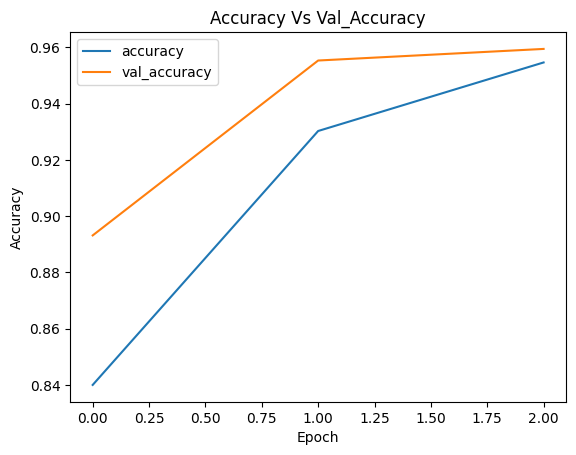

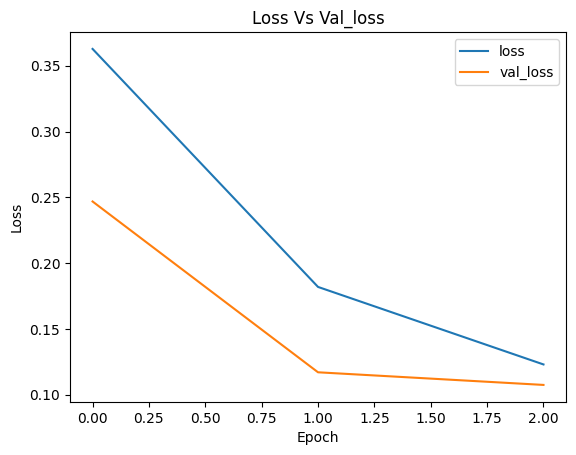

91/91 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         0.0     0.9499    0.9034    0.9261       818
         1.0     0.9630    0.9814    0.9721      2093

    accuracy                         0.9595      2911
   macro avg     0.9564    0.9424    0.9491      2911
weighted avg     0.9593    0.9595    0.9591      2911

EVERYTHING FINISHED FOR ADVANCED CNN MODEL!


In [20]:
if Train_Advanced_CNN == True:
    class Config_Advanced_CNN:
        epochs = 3 #70 is default (exp1)
        batch_size = 10 #10 is default (exp1)
        exp_name = 42 #Experiment Number counter 
        patience = 70 #10 # is default (exp1)
        initial_learning_rate=0.001 #Default Initial Learning Rate for ADAM: 0.001
        optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
        reduce_lr_every_10_epochs = True #Reduce the learning rate each 10 Epochs with the rate defined below. Default is False for exp1.
        lr_reduction_rate = 0.5 # Reduction Rate for reducing each 10 epochs. 0.5 means, that lr is halfed each 10 epochs.
        Conv1_filter_num = 32 # Number of filters in the convolutional layer (more means more shape-variations can be detected) 
        Conv1_filter_size = 3 # Size (e.g. 3 by 3) of single convolutional kernel. More means a more rough approach to detection of patterns.
        filepath_checkpoint = '../models/DL_Models/Advanced_CNN/experiment_'+str(exp_name) + '_'+str (Config_Sampling.sample_name) +'.weights.h5'
        filepath_accuracy_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+ str (Config_Sampling.sample_name) +'.accuracy_plot.png'
        filepath_loss_plot = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.loss_plot.png'
        filepath_classification_report = '../reports/figures/DL_Models/Advanced_CNN/experiment_'+str(exp_name) +  '_'+str (Config_Sampling.sample_name) +'.classification_report.txt'

    #Model structure: This is not changed during experiments.
    adv_cnn_model = tf.keras.models.Sequential()
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num, Config_Advanced_CNN.Conv1_filter_size, activation='relu', input_shape=(187, 1))) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Conv1D(Config_Advanced_CNN.Conv1_filter_num//2, Config_Advanced_CNN.Conv1_filter_size, activation='relu' )) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)) # We add one Conv1D layer to the model
    adv_cnn_model.add(tf.keras.layers.Flatten()) # After  
    adv_cnn_model.add(tf.keras.layers.Dropout(rate=0.2))
    adv_cnn_model.add(tf.keras.layers.Dense(120, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(60, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(20, activation=tf.keras.layers.LeakyReLU(alpha=0.001)))
    adv_cnn_model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    #Function for the learning rate scheduler
    def lr_scheduler(epoch, lr):
        if Config_Advanced_CNN.reduce_lr_every_10_epochs and epoch % 10 == 0: # %10 == 0 means each 10 epochs (only then no "rest" after dividing trough 10)
            return lr * Config_Advanced_CNN.lr_reduction_rate  # reduce the learning rate with the configured rate
        else:
            return lr

    # callback for the learning rate reduction schedule (function)
    lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
    
    #Model checkpoint: Saves the best model for all epochs with regards to the validation accuracy. Only weights (.h5) are saved.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=Config_Advanced_CNN.filepath_checkpoint,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    #Early stop callback: If validation accuracy does not change during the last XXX epochs, training is stopped (XXX is configured as patience)
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=Config_Advanced_CNN.patience)

    #Compilation of model with ADAM and custom lr, sparse_categorical_crossentropy since we have integers as class labels.
    adv_cnn_model.compile(optimizer=Config_Advanced_CNN.optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    adv_cnn_model.summary()

    
    """The following transformation of DataFrames to NumPy arrays and reshaping them is necessary to match the input requirements of the Convolutional Neural Network model.
     CNNs in TensorFlow typically expect input data in the form of NumPy arrays with specific shapes, especially when using Conv1D layers.
    This reshaping ensures that the data is in the correct format for training and inference."""
    train_array = train.to_numpy()
    test_array = test.to_numpy()
    train_reshaped = train_array.reshape(train_array.shape[0], train_array.shape[1], 1)
    test_reshaped = test_array.reshape(test_array.shape[0], test_array.shape[1], 1)
    
    #training the model and storing all results in training history. aside from the datasets, all arguments are called from our config-class. Also calling the respective callbacks.
    adv_cnn_model_history = adv_cnn_model.fit(train_reshaped, train_target, epochs=Config_Advanced_CNN.epochs, batch_size=Config_Advanced_CNN.batch_size, 
                                      validation_data=(test_reshaped, test_target), 
                                      callbacks=[model_checkpoint_callback, early_stop_callback])
    
    #some plots for early interpretion during the run
    plt.plot(adv_cnn_model_history.history['accuracy'])
    plt.plot(adv_cnn_model_history.history['val_accuracy'])
    plt.legend(["accuracy","val_accuracy"])
    plt.title(f'Accuracy Vs Val_Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.savefig(Config_Advanced_CNN.filepath_accuracy_plot)
    plt.show()
    plt.close()

    plt.plot(adv_cnn_model_history.history['loss'])
    plt.plot(adv_cnn_model_history.history['val_loss'])
    plt.legend(["loss","val_loss"])
    plt.title('Loss Vs Val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(Config_Advanced_CNN.filepath_loss_plot)
    plt.show()
    plt.close()

    #Predict on test set.
    predictions = adv_cnn_model.predict(test_reshaped).argmax(axis=1)

    #make classification report and save it directly as a file.
    report = classification_report(test_target, predictions, digits=4)
    print(report)
    with open(Config_Advanced_CNN.filepath_classification_report, 'w') as report_file:
        report_file.write(report)

    print("EVERYTHING FINISHED FOR ADVANCED CNN MODEL!")

else:
    print("ADVANCED CNN Model is not trained and evaluated")